# Lesson 1  Homework - Where's your city?

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import os
import random
from collections import defaultdict
import pandas as pd
import re

## Looking at the data

In [3]:
torch.cuda.set_device(0)

In [4]:
path = Path('/home/henripal/projects/maps/scraper/')

In [5]:
path.ls()

[PosixPath('/home/henripal/projects/maps/scraper/scraper'),
 PosixPath('/home/henripal/projects/maps/scraper/img'),
 PosixPath('/home/henripal/projects/maps/scraper/data')]

In [6]:
path_img = path/'img'

In [ ]:
fnames = get_image_files(path_img)

In [ ]:
city_to_file = defaultdict(list)

In [ ]:
for fname in fnames:
    city_to_file[fname.stem[:-1]].append(fname)

In [ ]:
city_list = list(city_to_file.keys())

In [ ]:
random.shuffle(city_list)

In [ ]:
train_pct = 0.80
train_idx = int(len(city_list) * train_pct) ; train_idx

In [ ]:
target_paths = []
target_labels = []
pat = r',+([A-z_+-ô\"\'\(\)]+)\d+.png$'
for train_city in city_list[:train_idx]:
    for train_file in city_to_file[train_city]:
        target_paths.append(str(Path('train',train_file.name)))
        country_name= re.search(pat, str(train_file)).group(1)
        target_labels.append(country_name)
for train_city in city_list[train_idx:]:
    for train_file in city_to_file[train_city]:
        target_paths.append(str(Path('test',train_file.name)))
        country_name= re.search(pat, str(train_file)).group(1)
        target_labels.append(country_name)

In [ ]:
df = pd.DataFrame({
    'label': target_labels,
    'name': target_paths,
})

In [ ]:
df = df[['name', 'label']]

In [ ]:
df

In [ ]:
df.to_csv(path_img/'labels.csv',index=False)

In [ ]:
for train_city in city_list[:train_idx]:
    for train_file in city_to_file[train_city]:
        start_file = str(train_file)
        target_file = str(train_file.parent/'train'/train_file.name)
        os.rename(start_file, target_file)

In [ ]:
for train_city in city_list[train_idx:]:
    for train_file in city_to_file[train_city]:
        start_file = str(train_file)
        target_file = str(train_file.parent/'test'/train_file.name)
        os.rename(start_file, target_file)

In [7]:
data = ImageDataBunch.from_csv(path_img, ds_tfms=get_transforms(), size=224, bs=256)
data.normalize(imagenet_stats)

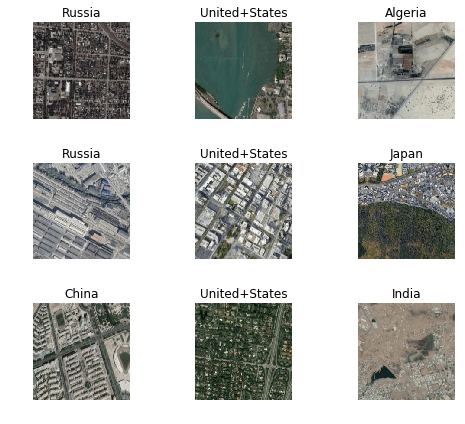

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

## Training: resnet34

In [9]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(7)

Total time: 14:31
epoch  train_loss  valid_loss  error_rate
1      2.431352    1.926598    0.475252    (02:02)
2      1.744314    1.485835    0.399664    (02:04)
3      1.533194    1.306648    0.357447    (02:04)
4      1.385806    1.182488    0.330347    (02:04)
5      1.251767    1.113583    0.310470    (02:04)
6      1.160208    1.065986    0.301008    (02:07)
7      1.132802    1.065085    0.300840    (02:04)



In [11]:
learn.save('resnet34-big-stage-1')

## Results

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

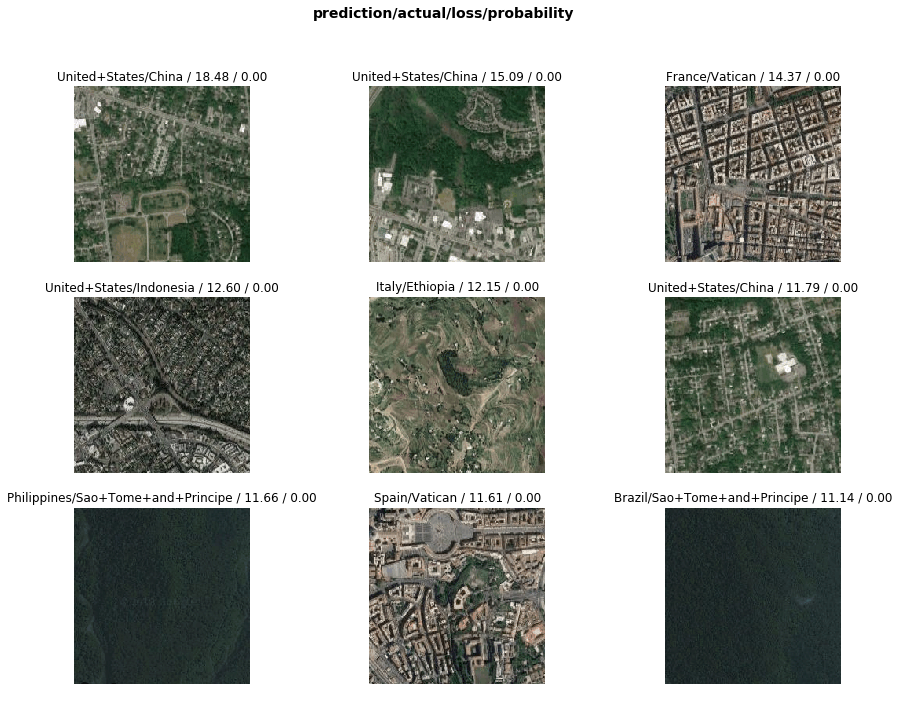

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
interp.most_confused(min_val=2)

[('Pakistan', 'India', 79),
 ('Canada', 'United+States', 58),
 ('Indonesia', 'Philippines', 50),
 ('Italy', 'Spain', 49),
 ('Germany', 'France', 41),
 ('Russia', 'Ukraine', 38),
 ('Poland', 'Germany', 37),
 ('France', 'Spain', 36),
 ('Ukraine', 'Russia', 36),
 ('Portugal', 'Spain', 34),
 ('Bangladesh', 'India', 34),
 ('Germany', 'United+Kingdom', 32),
 ('Czech+Republic', 'Germany', 32),
 ('Kazakhstan', 'Russia', 30),
 ('France', 'Germany', 27),
 ('Turkey', 'Spain', 27),
 ('Brazil', 'Philippines', 24),
 ('France', 'United+Kingdom', 23),
 ('Spain', 'Italy', 22),
 ('India', 'Philippines', 22),
 ('Germany', 'Poland', 21),
 ('Belarus', 'Russia', 21),
 ('India', 'Pakistan', 20),
 ('Ireland', 'United+Kingdom', 20),
 ('India', 'Thailand', 19),
 ('Netherlands', 'United+Kingdom', 19),
 ('Algeria', 'Italy', 18),
 ('Germany', 'United+States', 18),
 ('India', 'Mexico', 18),
 ('Colombia', 'Philippines', 18),
 ('Netherlands', 'Germany', 18),
 ('Germany', 'Belgium', 17),
 ('Germany', 'Netherlands', 17

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [12]:
learn.unfreeze()

In [ ]:
learn.load('stage-1')

In [13]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


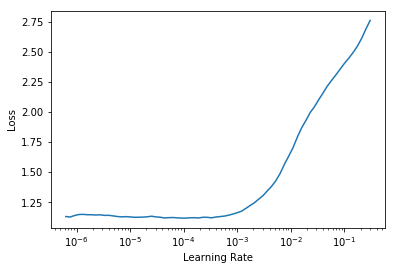

In [14]:
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-4))

Total time: 10:22
epoch  train_loss  valid_loss  error_rate
1      1.094779    1.052303    0.296697    (02:34)
2      1.048684    0.984621    0.276596    (02:37)
3      0.992562    0.951541    0.268365    (02:35)
4      0.943050    0.943218    0.266349    (02:34)



In [16]:
learn.save('resnet34-big-stage2')

In [ ]:
i = 5
img = open_image(learn.path/'train'/os.listdir('../scraper/img/train')[i])
os.listdir('../scraper/img/train')[i]

In [ ]:
img

In [ ]:
learn.predict(img)

In [ ]:
learn.path, learn.model_dir


In [ ]:
get_transforms()

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=299, bs=32)
data.normalize(imagenet_stats)

In [ ]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In this case it doesn't, so let's go back to our previous model.

In [ ]:
learn.load('stage-1-50')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=1)